# 1. Includes



In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

# Eigene Module
import util.visual as vis
import util.utils as util
import util.model as md
import util.dataset as ds

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle
#sys.path.insert(1, os.path.join(sys.path[0], '../thirdparty'))
#sys.path.append('../thirdparty/review_object_detection_metrics')
#import src.evaluators.coco_evaluator as coco
#from src.bounding_box import BoundingBox

2.4.1
True
[]


# 2. Definitions
Hier werden die Dateipfade und Namen definiert

In [2]:
# Definitionen für selbst generierte Daten (Modelle, Graphen, ...)
models_path = '../data/models/'
model_name = 'experi_model'
logs_path = '../data/logs/'
chkpts_path = '../data/checkpoints/'
graphs_path = '../data/graphs/'
tables_path = '../data/tables/'

# Namen der Unterordner des Simulator Datasets ('1_1/', '1_2/', ..., '2_5/')
subfolders = []
for i in range(1, 3):
    for j in range(1, 6):
        subfolders.append(str(i) + '_' + str(j) + '/')

img_path = 'D:/workspace/datasets/simulator/1_1/images/'
csv_path = 'D:/workspace/datasets/simulator/1_1/labels.csv'
neg_csv_path = '../data/datasets/simulator/labels_with_negatives.csv'
params = util.get_params('../params.yaml')

yolo_anchors = np.array([(0.1499, 0.3052), (0.0563, 0.0748)], np.float32)

# 3. Playground

In [3]:
model = tf.keras.models.load_model('../data/models/experimodel/experimodel.hdf5', custom_objects={'yolo_loss': md.YoloLoss(yolo_anchors)})
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 160, 24)      240       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 160, 24)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 160, 24)      96        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 80, 24)        5208      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 80, 24)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 80, 24)        96    

In [4]:
testset = ds.load_tfrecord_dataset('../data/datasets/ImageTagger/records/test/test_0.record').map(lambda x,y: (x, util.preprocess_true_boxes(y, params.model.grid.shape))).batch(1).skip(10).take(1)
tst = []
for img, lbl in testset:
    #print(lbl)
    #vis.visualize_output_tensor(lbl, lbl, tf.squeeze(img), params.dataset.image.size, params.model.grid.shape, conf_threshold=0.3)
    #true_bboxes = util.postprocess_dataset_labels(lbl, params.dataset.image.size)
    #true_bboxes = util.get_bbox_list_from_labels(lbl)
    #ax = vis.plot_image_with_grid(tf.squeeze(img), params.dataset.image.size, params.model.grid.shape)
    #vis.plot_bbox_list(ax, true_bbox_list=true_bboxes)
    #print(true_bboxes)
    tst = lbl
    true_bboxes = util.postprocess_dataset_labels(lbl, params.dataset.image.size)

In [5]:
out = np.array([
    [[[0,0,0,0,0],[0,0,0,0,0]], [[0,0,0,0,1],[0,0,0,0,0]], [[0,0,0,0,0],[0,0,0,0,0]]],
    [[[0,0,0,0,0],[0,0,0,0,0]], [[0,0,0,0,0],[0,0,0,0,0]], [[0,0,0,0,0],[0,0,0,0,0]]],
    ])
#print(out.shape)
#print(out[0, 0, 1, :])
mod_tst = tf.tensor_scatter_nd_update(tst, [[0,0,0,1,4], [0,3,3,1,4], [0,4,4,1,4]], [1, 1, 1])
#print(mod_tst)
true_bboxes = util.postprocess_dataset_labels(tf.cast(mod_tst, tf.float32), params.dataset.image.size)
#print(true_bboxes)
conf_true = mod_tst[..., 4]
xy_true = mod_tst[..., 0:2]
wh_true = mod_tst[..., 2:4]
obj_mask = tf.expand_dims(conf_true, axis=-1)
xy_loss = tf.reduce_sum(tf.square(xy_true - xy_true) * obj_mask) / 2.0
print(tf.shape(mod_tst))
print(tf.shape(mod_tst)[-4:-2])
#print(xy_loss)
#print(obj_mask)

tf.Tensor([ 1  8 10  2  5], shape=(5,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)


image = tf.keras.preprocessing.image.load_img('/home/david/workspace/hskl-robocupgermanopen-2021/ObjectDetection/IMG_20210312_152911 2.jpg', color_mode="grayscale", target_size=(params.dataset.image.size[1], params.dataset.image.size[0]))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
pred = model.predict(input_arr)
#print(pred)
bbox_list_corners = util.postprocess_model_output(pred, params.dataset.image.size, conf_threshold=0.3)
#print(bbox_list_corners)
ax = vis.plot_image_with_grid(image, params.dataset.image.size, params.model.grid.shape)
vis.plot_bbox_list(ax, pred_bbox_list=bbox_list_corners)

tf.Tensor([ 8 10], shape=(2,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)
tf.Tensor([ 8 10], shape=(2,), dtype=int32)


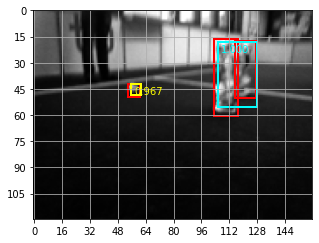

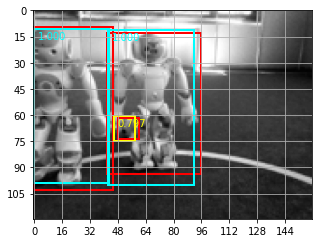

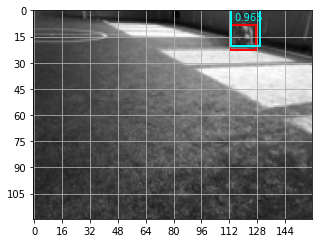

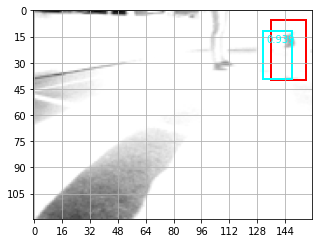

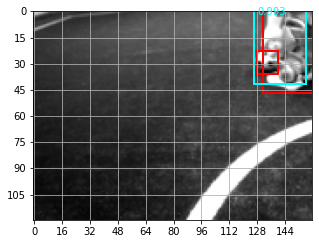

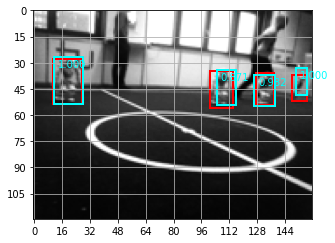

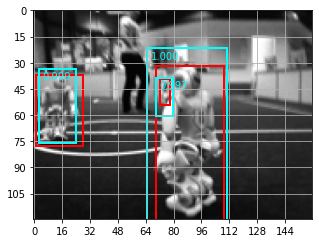

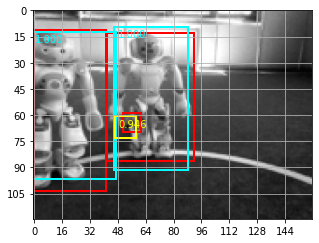

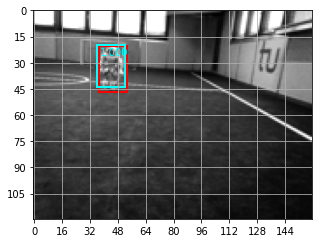

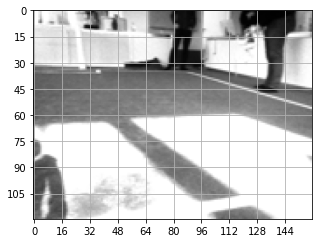

In [10]:
testset = ds.load_tfrecord_dataset('../data/datasets/ImageTagger/records/test/test_1.record').map(lambda x,y: (x, util.preprocess_true_boxes(y, params.model.grid.shape))).batch(1).skip(15).take(10)

true_bboxes_list = []
pred_bboxes_list = []
for id, (img, lbl) in enumerate(testset):
    pred = model.predict([img])

    true_bboxes = util.postprocess_dataset_labels(lbl, params.dataset.image.size)
    pred_bboxes = util.postprocess_model_output(tf.expand_dims(pred, axis=0), params.dataset.image.size, 0.6, yolo_anchors) 

    ax = vis.plot_image_with_grid(tf.squeeze(img), params.dataset.image.size, params.model.grid.shape)
    vis.plot_bbox_list(ax, true_bbox_list=true_bboxes, pred_bbox_list=pred_bboxes)

In [7]:
csv_dir = '/home/david/workspace/hskl-robocupgermanopen-2021/ObjectDetection/data/datasets/ImageTagger/labels'
labels = []
csv_files = os.listdir(csv_dir)

for i, file in enumerate(csv_files):
    ds_name = os.path.splitext(file)[0]
    csv_path = os.path.join(csv_dir, file)
    
    examples = pd.read_csv(csv_path, index_col=None, header=0)
    labels.append(examples[examples['class'] != 0])

labels = pd.concat(labels, axis=0, ignore_index=True)
labels['w'] = (labels['xmax'] - labels['xmin']) / 640
labels['h'] = (labels['ymax'] - labels['ymin']) / 480
avg_w_nao = labels[labels['class'] == 1]['w'].mean()
avg_w_ball = labels[labels['class'] == 2]['w'].mean()
avg_h_nao = labels[labels['class'] == 1]['h'].mean()
avg_h_ball = labels[labels['class'] == 2]['h'].mean() 
print(labels)
print('NAO: ' + str(avg_w_nao) + ', ' + str(avg_h_nao))
print('BALL: ' + str(avg_w_ball) + ', ' + str(avg_h_ball))

                                  filename  class   xmin   ymin   xmax   ymax  \
0      16_02_2018__11_30_01_0000_upper.png      1  267.0  150.0  294.0  196.0   
1      16_02_2018__11_30_01_0000_upper.png      1  330.0  152.0  352.0  190.0   
2      16_02_2018__11_30_01_0000_upper.png      1  383.0  147.0  405.0  181.0   
3      16_02_2018__11_30_01_0001_upper.png      1  309.0  171.0  337.0  219.0   
4      16_02_2018__11_30_01_0002_upper.png      1  371.0   71.0  402.0  128.0   
...                                    ...    ...    ...    ...    ...    ...   
47172  26_01_2018__13_46_49_1188_upper.png      1    4.0   48.0   29.0  103.0   
47173  26_01_2018__13_46_49_1188_upper.png      1  173.0   61.0  216.0  142.0   
47174  26_01_2018__13_46_49_1188_upper.png      1  240.0   53.0  306.0  225.0   
47175  26_01_2018__13_46_49_1188_upper.png      2  315.0  140.0  334.0  159.0   
47176  26_01_2018__13_46_49_1188_upper.png      1  222.0   58.0  281.0  196.0   

              w         h  

tf.Tensor(
[[103.25      16.250002 117.        60.750004   1.         0.      ]
 [115.25      17.249998 126.999985  50.         1.         0.      ]
 [ 53.75      42.25      61.000004  49.500004   1.         1.      ]], shape=(3, 6), dtype=float32)
tf.Tensor([49.92502898 49.84741905 50.07497102 50.15258095  1.          0.        ], shape=(6,), dtype=float64)


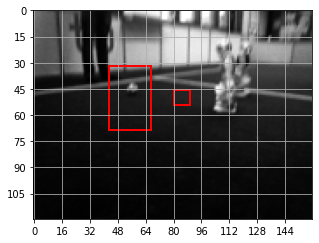

In [8]:
testset = ds.load_tfrecord_dataset('../data/datasets/ImageTagger/records/test/test_1.record').map(lambda x,y: (x, util.preprocess_true_boxes(y, params.model.grid.shape))).batch(1).skip(15).take(1)

for id, (img, lbl) in enumerate(testset):
    pred = model.predict([img])
    true_bboxes = util.postprocess_dataset_labels(lbl, params.dataset.image.size)  
    print(true_bboxes)
    print(util.convert_to_corners(np.array([50.0, 50.0, avg_w_nao, avg_h_nao, 1, 0])))
    anchors = [ util.convert_to_corners(np.array([55.0, 50.0, avg_w_nao * 160, avg_h_nao * 120, 1, 0])), 
                util.convert_to_corners(np.array([85.0, 50.0, avg_w_ball * 160, avg_h_ball * 120, 1, 0]))]
    ax = vis.plot_image_with_grid(tf.squeeze(img), params.dataset.image.size, params.model.grid.shape)
    vis.plot_bbox_list(ax, true_bbox_list=anchors)